In [613]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import *
from random import seed
from scipy import stats
import seaborn as sns
import pingouin as pg
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
import statsmodels.api as sm
from statsmodels.stats.api import anova_lm
from statsmodels.formula.api import ols
from statsmodels.regression import linear_model
from sklearn.metrics import explained_variance_score
from sklearn.linear_model import LassoCV, RidgeCV, Lasso
%matplotlib inline

seed(888)
pd.set_option('display.max_columns', None)

# 1 Load data from "3. BrainAge"

In [614]:
# load data from pickle and convert to dataframe
brain_test = pd.read_pickle("3_brain_test.pkl")
brain_train = pd.read_pickle("3_brain_train.pkl")
main_test = pd.read_pickle("3_main_test.pkl")
main_train = pd.read_pickle("3_main_train.pkl")
brain_test = pd.DataFrame(brain_test)
brain_train = pd.DataFrame(brain_train)
main_test = pd.DataFrame(main_test)
main_train = pd.DataFrame(main_train)

In [615]:
main_test = main_test[main_test["Excluded"]==0]

# 2 Basic distributions

## 2.1 Data and Descriptives

In [616]:
main_test.head()

,Age,Gender,TPA,VPA,MPA,MVPA,LPA,BMI,ECGW,ECGHR,SRLPA,SRMPA,SRVPA,FI,HGL,HGR,IS,Smoking,SES,HR,JPA,DBP,SBP,WS,Excluded,BADA2009,BADASEG,BADDesikan,BADAll
2,73.0,Female,2550.2400,10.0800,352.8000,372.9600,2187.3600,26.9,NaN,NaN,1188.0,120.0,0.0,9.0,20.0,26.0,11025,No,-3.469800,57.0,NaN,82.0,142.0,Steady average pace,0,6.682648,11.366626,-4.257749,4.824975
12,56.0,Male,1601.3088,18.9504,227.4048,265.3056,1354.9536,28.4,120.0,117.0,396.0,900.0,0.0,NaN,35.0,39.0,11025,No,0.642148,60.0,Never/rarely,96.0,157.0,Brisk pace,0,2.602614,-2.290451,2.613243,-4.043574
21,56.0,Female,2465.2224,29.1168,427.0464,485.2800,2009.0592,33.6,NaN,NaN,2970.0,720.0,240.0,NaN,18.0,18.0,11025,No,-5.554810,49.0,Sometimes,75.0,134.0,Steady average pace,0,-4.707409,-9.699509,17.604512,-4.769448
25,70.0,Female,2746.1376,10.0224,210.4704,230.5152,2525.6448,22.1,NaN,NaN,2772.0,240.0,320.0,NaN,22.0,20.0,11026,No,-0.812078,60.0,NaN,87.0,170.0,Steady average pace,0,-9.148577,-17.918862,-8.690381,-14.235593
29,75.0,Female,2732.1840,10.0080,520.4160,540.4320,2201.7600,26.2,NaN,NaN,4158.0,5040.0,0.0,NaN,24.0,24.0,11027,No,3.683690,68.0,NaN,79.0,139.0,Steady average pace,0,10.046315,4.230943,2.981511,5.298075


### 2.1.1 Test set

In [617]:
female = main_test[main_test["Gender"] == "Female"]
male = main_test[main_test["Gender"]== "Male"]

print(female.shape)
print(male.shape)

print("Age")
mean = female["Age"].mean()
print("Female", mean)
std = female["Age"].std()
print("Female",std)
mean = male["Age"].mean()
print("Male",mean)
std = male["Age"].std()
print("Male",std)

print("LPA")
mean = female["LPA"].mean()
print("Female", mean)
std = female["LPA"].std()
print("Female",std)
mean = male["LPA"].mean()
print("Male",mean)
std = male["LPA"].std()
print("Male",std)

print("MPA")
mean = female["MPA"].mean()
print("Female", mean)
std = female["MPA"].std()
print("Female",std)
mean = male["MPA"].mean()
print("Male",mean)
std = male["MPA"].std()
print("Male",std)

print("VPA")
mean = female["VPA"].mean()
print("Female", mean)
std = female["VPA"].std()
print("Female",std)
mean = male["VPA"].mean()
print("Male",mean)
std = male["VPA"].std()
print("Male",std)

print("BMI")
mean = female["BMI"].mean()
print("Female", mean)
std = female["BMI"].std()
print("Female",std)
mean = male["BMI"].mean()
print("Male",mean)
std = male["BMI"].std()
print("Male",std)

# add all variables here

(4184, 29)
(3265, 29)
Age
Female 63.58652007648183
Female 7.590787345844849
Male 65.591730474732
Male 7.940549181252069
LPA
Female 2069.775433652008
Female 412.6352640137526
Male 1893.2957784992338
Male 413.9385748689674
MPA
Female 493.6033686424476
Female 225.0939216811219
Male 478.4965591424197
Male 224.96213059810955
VPA
Female 30.9741694072658
Female 39.56276691493679
Male 38.07106842266466
Male 47.84760788221636
BMI
Female 25.93050642112915
Female 4.516658165008668
Male 26.84780593325093
Male 3.7104870147034847


### 2.1.2 Train set

In [618]:
female = main_train[main_train["Gender"] == "Female"]
male = main_train[main_train["Gender"]== "Male"]

print(female.shape)
print(male.shape)

print("Age")
mean = female["Age"].mean()
print("Female", mean)
std = female["Age"].std()
print("Female",std)
mean = male["Age"].mean()
print("Male",mean)
std = male["Age"].std()
print("Male",std)

print("SRLPA")
mean = female["SRLPA"].mean()
print("Female", mean)
std = female["SRLPA"].std()
print("Female",std)
mean = male["SRLPA"].mean()
print("Male",mean)
std = male["SRLPA"].std()
print("Male",std)

print("SRMPA")
mean = female["SRMPA"].mean()
print("Female", mean)
std = female["SRMPA"].std()
print("Female",std)
mean = male["SRMPA"].mean()
print("Male",mean)
std = male["SRMPA"].std()
print("Male",std)

print("SRVPA")
mean = female["SRVPA"].mean()
print("Female", mean)
std = female["SRVPA"].std()
print("Female",std)
mean = male["SRVPA"].mean()
print("Male",mean)
std = male["SRVPA"].std()
print("Male",std)

print("BMI")
mean = female["BMI"].mean()
print("Female", mean)
std = female["BMI"].std()
print("Female",std)
mean = male["BMI"].mean()
print("Male",mean)
std = male["BMI"].std()
print("Male",std)

# add all variables here

(11134, 18242)
(10322, 18242)
Age
Female 63.8388719238369
Female 7.505493279921983
Male 65.01346638248401
Male 7.751725482615913
SRLPA
Female 983.3467157293497
Female 1032.8455951926849
Male 928.1347165657678
Male 1006.8024841652684
SRMPA
Female 837.8479789103691
Female 1113.2985200812966
Male 816.8184920198129
Male 1131.1648863832404
SRVPA
Female 574.4173989455185
Female 920.0381928918255
Male 740.2241056686846
Male 1146.3578505046185
BMI
Female 26.14613357564743
Female 4.575541355639641
Male 27.187759905845425
Male 3.7425534688910638


## 2.2 Train vs. Test

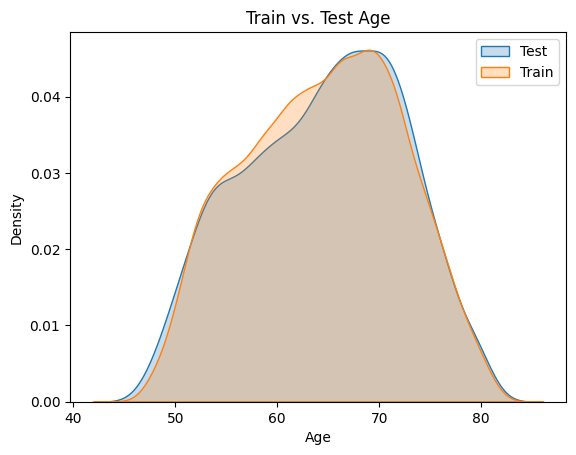

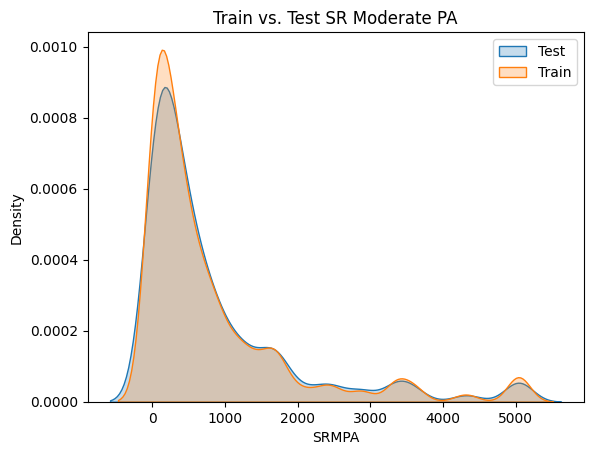

In [619]:
plt.figure()
sns.kdeplot(data = main_test, x= 'Age', fill=True, label = "Test")
sns.kdeplot(data = main_train, x= 'Age', fill=True, label = "Train")
plt.legend()
plt.title("Train vs. Test Age")
plt.show()

plt.figure()
sns.kdeplot(data = main_test, x= 'SRMPA', fill=True, label = "Test")
sns.kdeplot(data= main_train, x= 'SRMPA', fill=True, label = "Train")
plt.legend()
plt.title("Train vs. Test SR Moderate PA")
plt.show()

## 2.3 Age and BrainAge

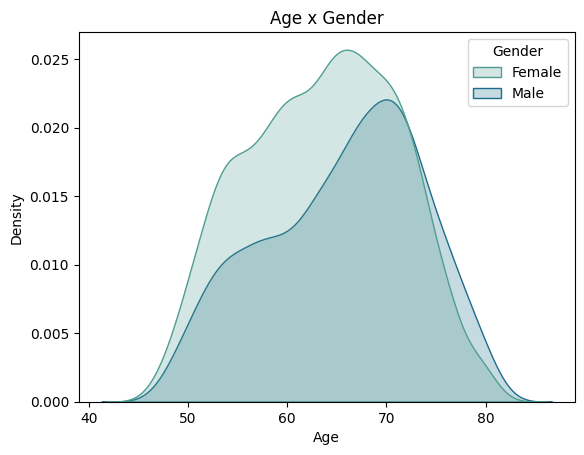

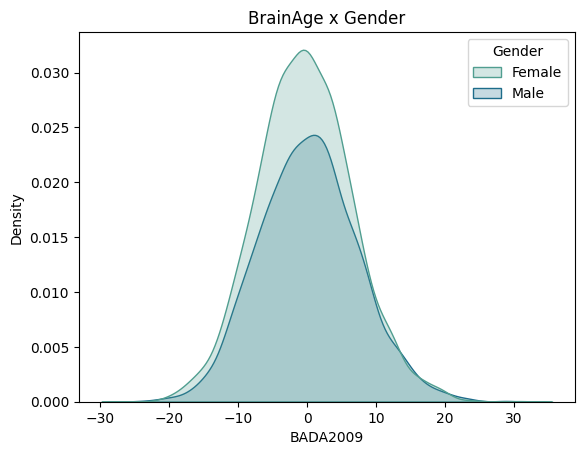

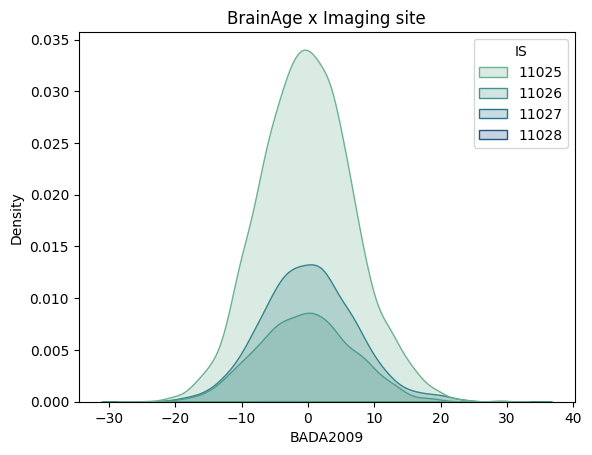

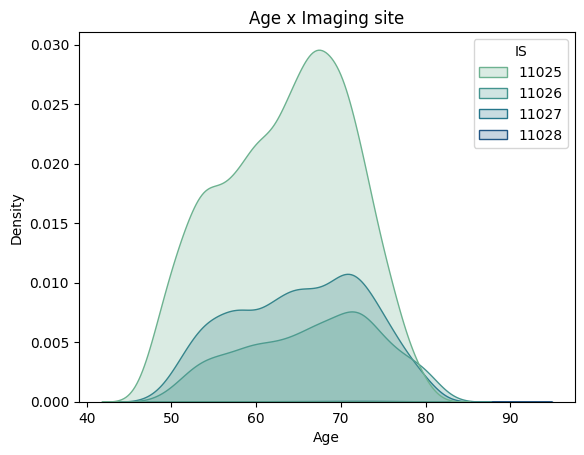

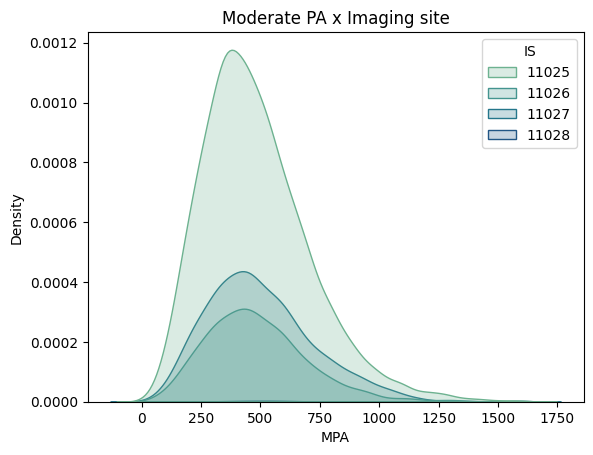

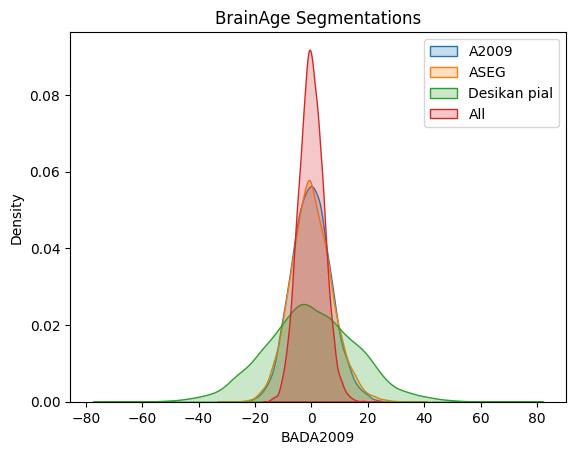

In [620]:
plt.figure()
sns.kdeplot(data = main_test, x= 'Age', hue = 'Gender', fill=True, palette = "crest")
plt.title("Age x Gender")
plt.show()

plt.figure()
sns.kdeplot(data = main_test, x= 'BADA2009', hue = 'Gender', fill=True, palette = "crest")
plt.title("BrainAge x Gender")
plt.show()

plt.figure()
sns.kdeplot(data = main_test, x= 'BADA2009', hue = 'IS', fill=True, palette = "crest")
plt.title("BrainAge x Imaging site")
plt.show()

plt.figure()
sns.kdeplot(data = main_test, x= 'Age', hue = 'IS', fill=True, palette = "crest")
plt.title("Age x Imaging site")
plt.show()

plt.figure()
sns.kdeplot(data = main_test, x= 'MPA', hue = 'IS', fill=True, palette = "crest")
plt.title("Moderate PA x Imaging site")
plt.show()


plt.figure()
sns.kdeplot(data = main_test, x= 'BADA2009', fill=True, label="A2009")
sns.kdeplot(data = main_test, x= 'BADASEG', fill=True, label="ASEG")
sns.kdeplot(data = main_test, x= 'BADDesikan', fill=True, label="Desikan pial")
sns.kdeplot(data = main_test, x= 'BADAll', fill=True, label="All")
plt.title("BrainAge Segmentations")
plt.legend()
plt.show()

## 2.4 Physical activity

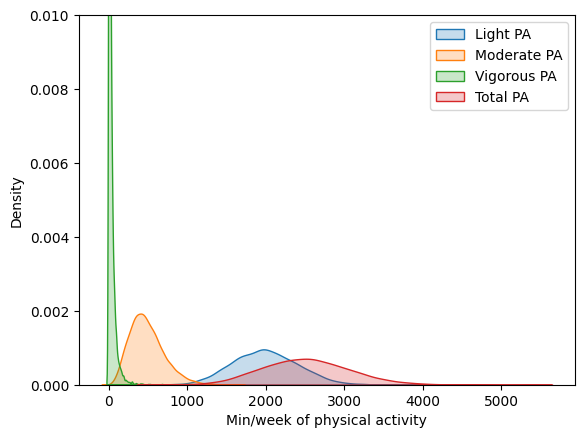

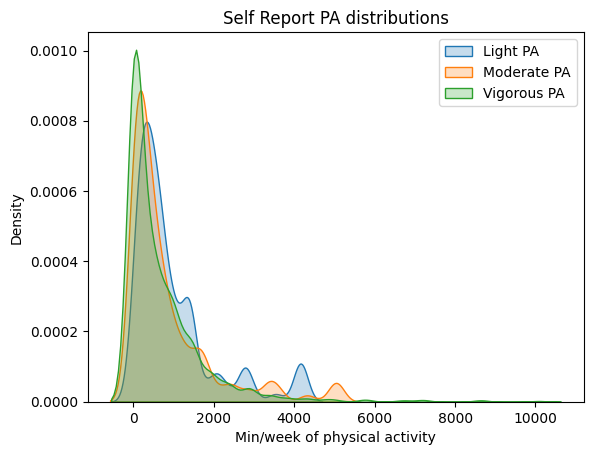

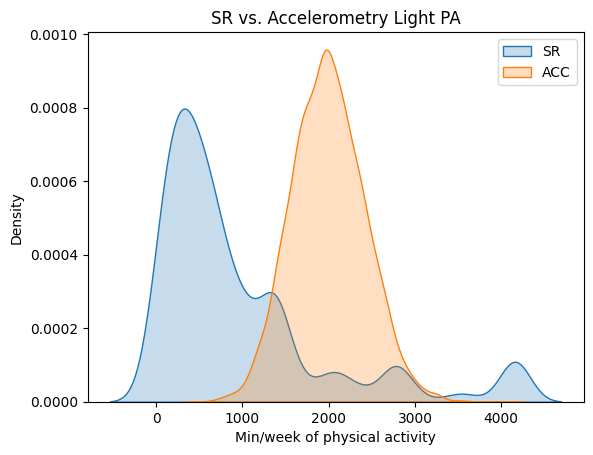

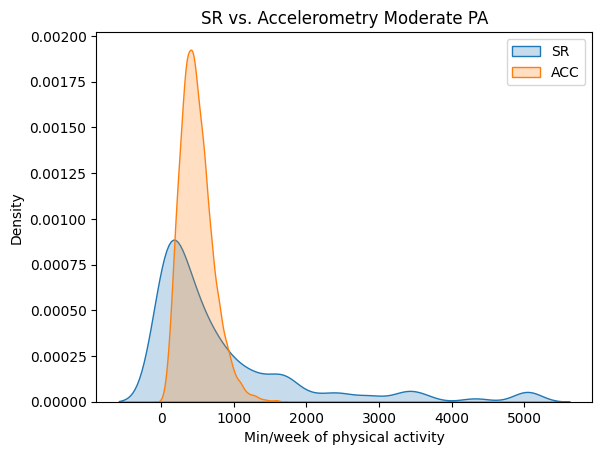

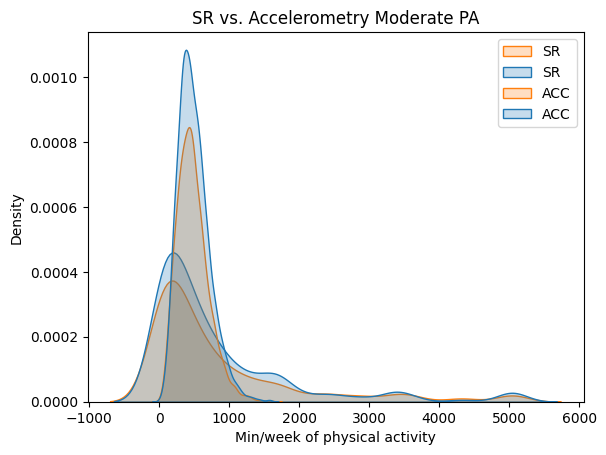

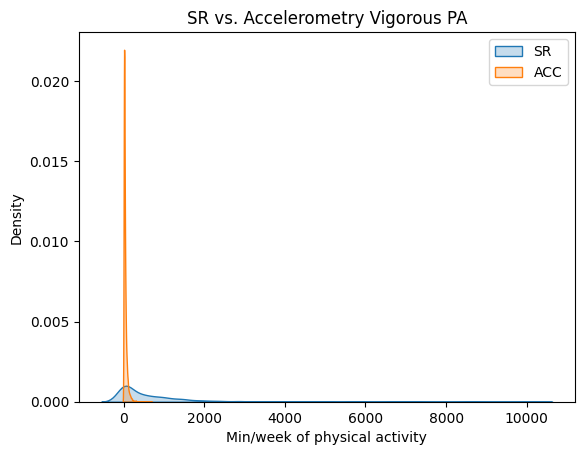

In [621]:
plt.figure()
sns.kdeplot(data = main_test, x= 'LPA', fill=True, label = "Light PA")
sns.kdeplot(data = main_test, x= 'MPA', fill=True, label = "Moderate PA")
sns.kdeplot(data = main_test, x= 'VPA', fill=True, label = "Vigorous PA")
sns.kdeplot(data = main_test, x= 'TPA', fill=True, label = "Total PA")
plt.xlabel("Min/week of physical activity")
plt.legend()
plt.ylim(0,0.01)
plt.show()

plt.figure()
sns.kdeplot(data = main_test, x= 'SRLPA', fill=True, label = "Light PA")
sns.kdeplot(data = main_test, x= 'SRMPA', fill=True, label = "Moderate PA")
sns.kdeplot(data = main_test, x= 'SRVPA', fill=True, label = "Vigorous PA")
plt.xlabel("Min/week of physical activity")
plt.title("Self Report PA distributions")
plt.legend()
plt.show()

plt.figure()
sns.kdeplot(data = main_test, x= 'SRLPA', fill=True, label = "SR")
sns.kdeplot(data = main_test, x= 'LPA', fill=True, label = "ACC")
plt.xlabel("Min/week of physical activity")
plt.title("SR vs. Accelerometry Light PA")
plt.legend()
plt.show()

plt.figure()
sns.kdeplot(data = main_test, x= 'SRMPA', fill=True, label = "SR")
sns.kdeplot(data = main_test, x= 'MPA', fill=True, label = "ACC")
plt.xlabel("Min/week of physical activity")
plt.title("SR vs. Accelerometry Moderate PA")
plt.legend()
plt.show()

plt.figure()
sns.kdeplot(data = main_test, x= 'SRMPA', hue = "Gender", fill=True, label = "SR")
sns.kdeplot(data = main_test, x= 'MPA', hue = "Gender", fill=True, label = "ACC")
plt.xlabel("Min/week of physical activity")
plt.title("SR vs. Accelerometry Moderate PA")
plt.legend()
plt.show()

plt.figure()
sns.kdeplot(data = main_test, x= 'SRVPA', fill=True, label = "SR")
sns.kdeplot(data = main_test, x= 'VPA', fill=True, label = "ACC")
plt.xlabel("Min/week of physical activity")
plt.title("SR vs. Accelerometry Vigorous PA")
plt.legend()
plt.show()

## 2.5 Fitness

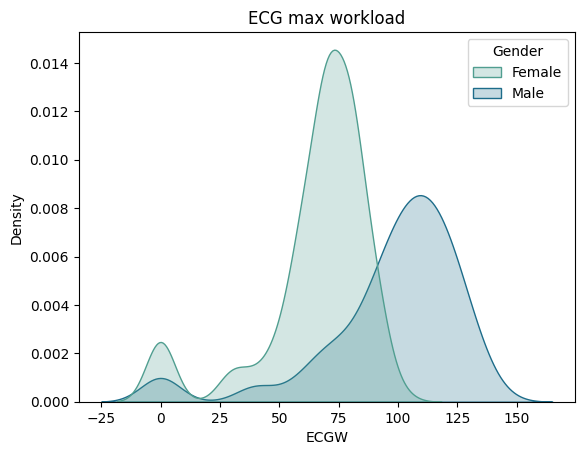

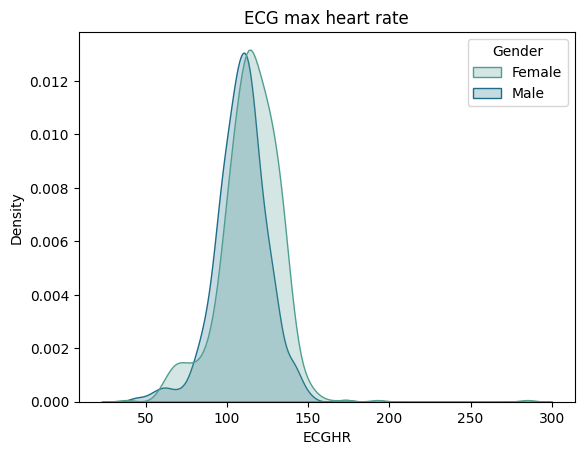

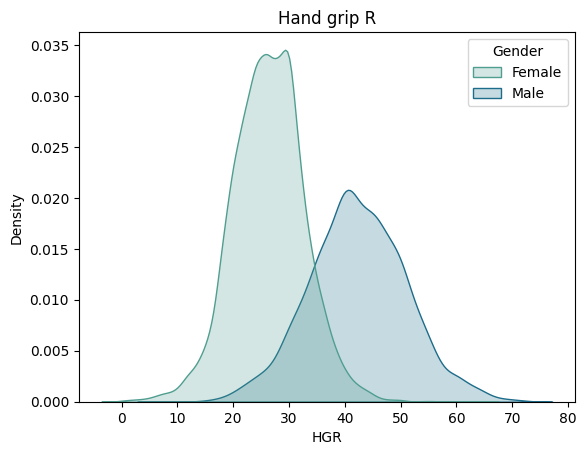

Walking speed: Brisk pace              3849
Steady average pace     3395
Slow pace                188
None of the above          7
Prefer not to answer       1
Name: WS, dtype: int64


In [622]:
plt.figure()
sns.kdeplot(data = main_test, x= 'ECGW', hue = 'Gender', fill=True, palette = "crest")
plt.title("ECG max workload")
plt.show()

plt.figure()
sns.kdeplot(data = main_test, x= 'ECGHR', hue = 'Gender', fill=True, palette = "crest")
plt.title("ECG max heart rate")
plt.show()

plt.figure()
sns.kdeplot(data = main_test, x= 'HGR', hue = 'Gender', fill=True, palette = "crest")
plt.title("Hand grip R")
plt.show()

print("Walking speed:", main_test["WS"].value_counts())

## 2.6 Health

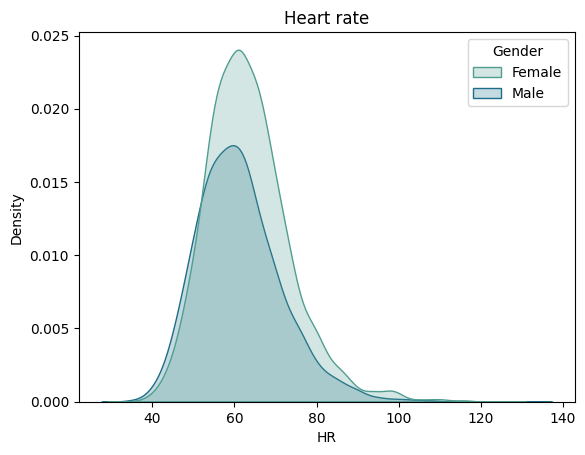

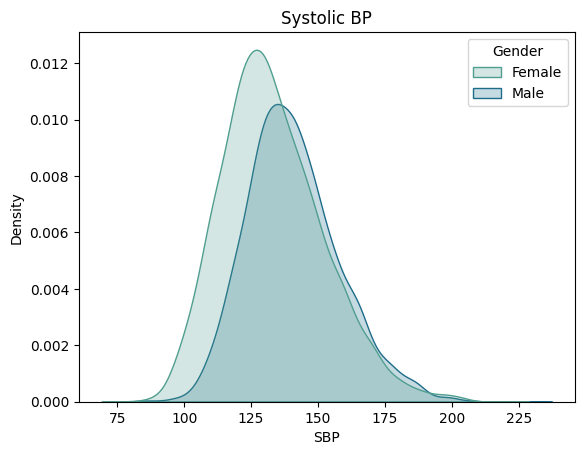

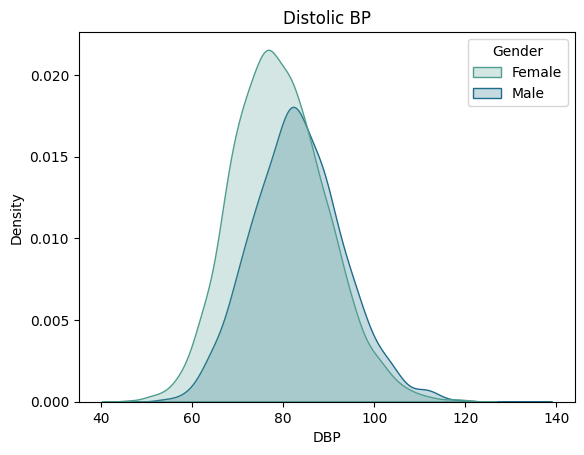

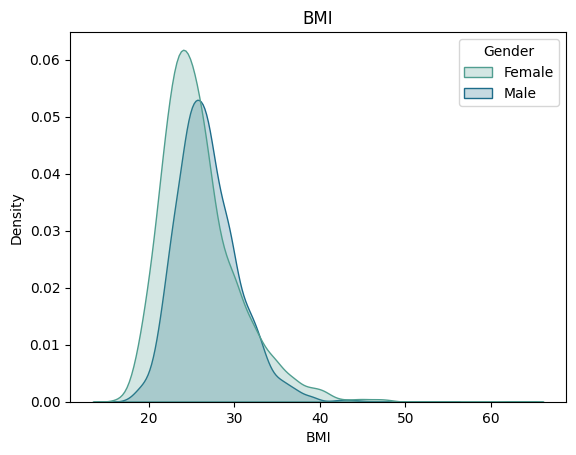

In [623]:
plt.figure()
sns.kdeplot(data = main_test, x= 'HR', hue = 'Gender', fill=True, palette = "crest")
plt.title("Heart rate")
plt.show()

plt.figure()
sns.kdeplot(data = main_test, x= 'SBP', hue = 'Gender', fill=True, palette = "crest")
plt.title("Systolic BP")
plt.show()

plt.figure()
sns.kdeplot(data = main_test, x= 'DBP', hue = 'Gender', fill=True, palette = "crest")
plt.title("Distolic BP")
plt.show()

plt.figure()
sns.kdeplot(data = main_test, x= 'BMI', hue = 'Gender', fill=True, palette = "crest")
plt.title("BMI")
plt.show()

## 2.7 Other variables

Smoking: No                          7035
Yes, on most or all days     264
Only occasionally            147
Prefer not to answer           1
Name: Smoking, dtype: int64
Job PA: Never/rarely            3684
Sometimes                860
Usually                  221
Always                   193
Do not know                1
Prefer not to answer       0
Name: JPA, dtype: int64


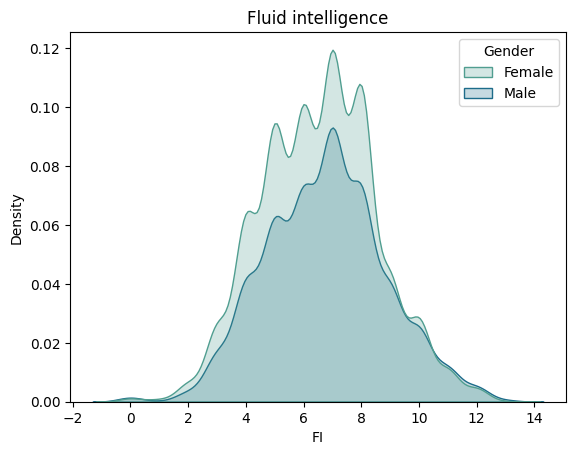

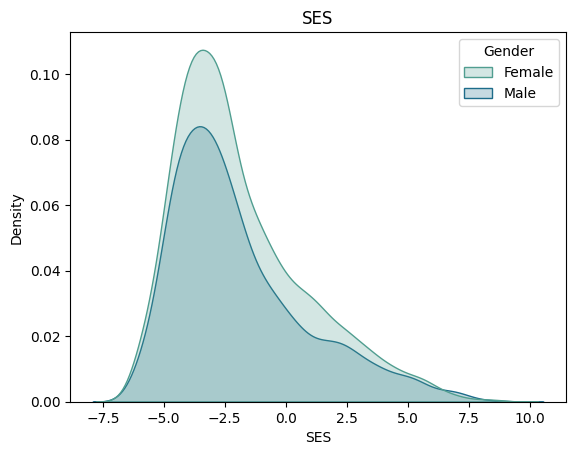

In [624]:
print("Smoking:", main_test["Smoking"].value_counts())
print("Job PA:", main_test["JPA"].value_counts())

plt.figure()
sns.kdeplot(data = main_test, x= 'FI', hue = 'Gender', fill=True, palette = "crest")
plt.title("Fluid intelligence")
plt.show()

plt.figure()
sns.kdeplot(data = main_test, x= 'SES', hue = 'Gender', fill=True, palette = "crest")
plt.title("SES")
plt.show()

# 3 Recode variables

In [625]:
# 1 = Cheadle;  2 = Reading;  3 = Newcastle;  4 = Bristol
main_test['IS'] = main_test['IS'].map({'11025': 1, '11026': 2,'11027': 3, '11028': 4})
main_test["Smoking"] = main_test["Smoking"].map({"No":0, "Only occasionally":1, "Yes, on most or all days":2})
main_test["Gender"] = main_test["Gender"].map({"Female":0, "Male":1})
main_test["Gender"] = main_test["Gender"].astype("int")
main_test["JPA"] = main_test["JPA"].map({"Never/rarely":0, "Sometimes":1, "Usually":2,"Always":3})
main_test["WS"] = main_test["WS"].map({"Slow pace":0, "Steady average pace":1, "Brisk pace":2})

del main_test["BADDesikan"]
del main_test["BADASEG"]
del main_test["Excluded"]
del main_test["BADAll"]

main_test = main_test.rename(columns={"BADA2009": "BA"})

main_test = pd.DataFrame(main_test)
main_test = stats.zscore(main_test,nan_policy='omit')

# 4 Simple correlation heatmap

<AxesSubplot:>

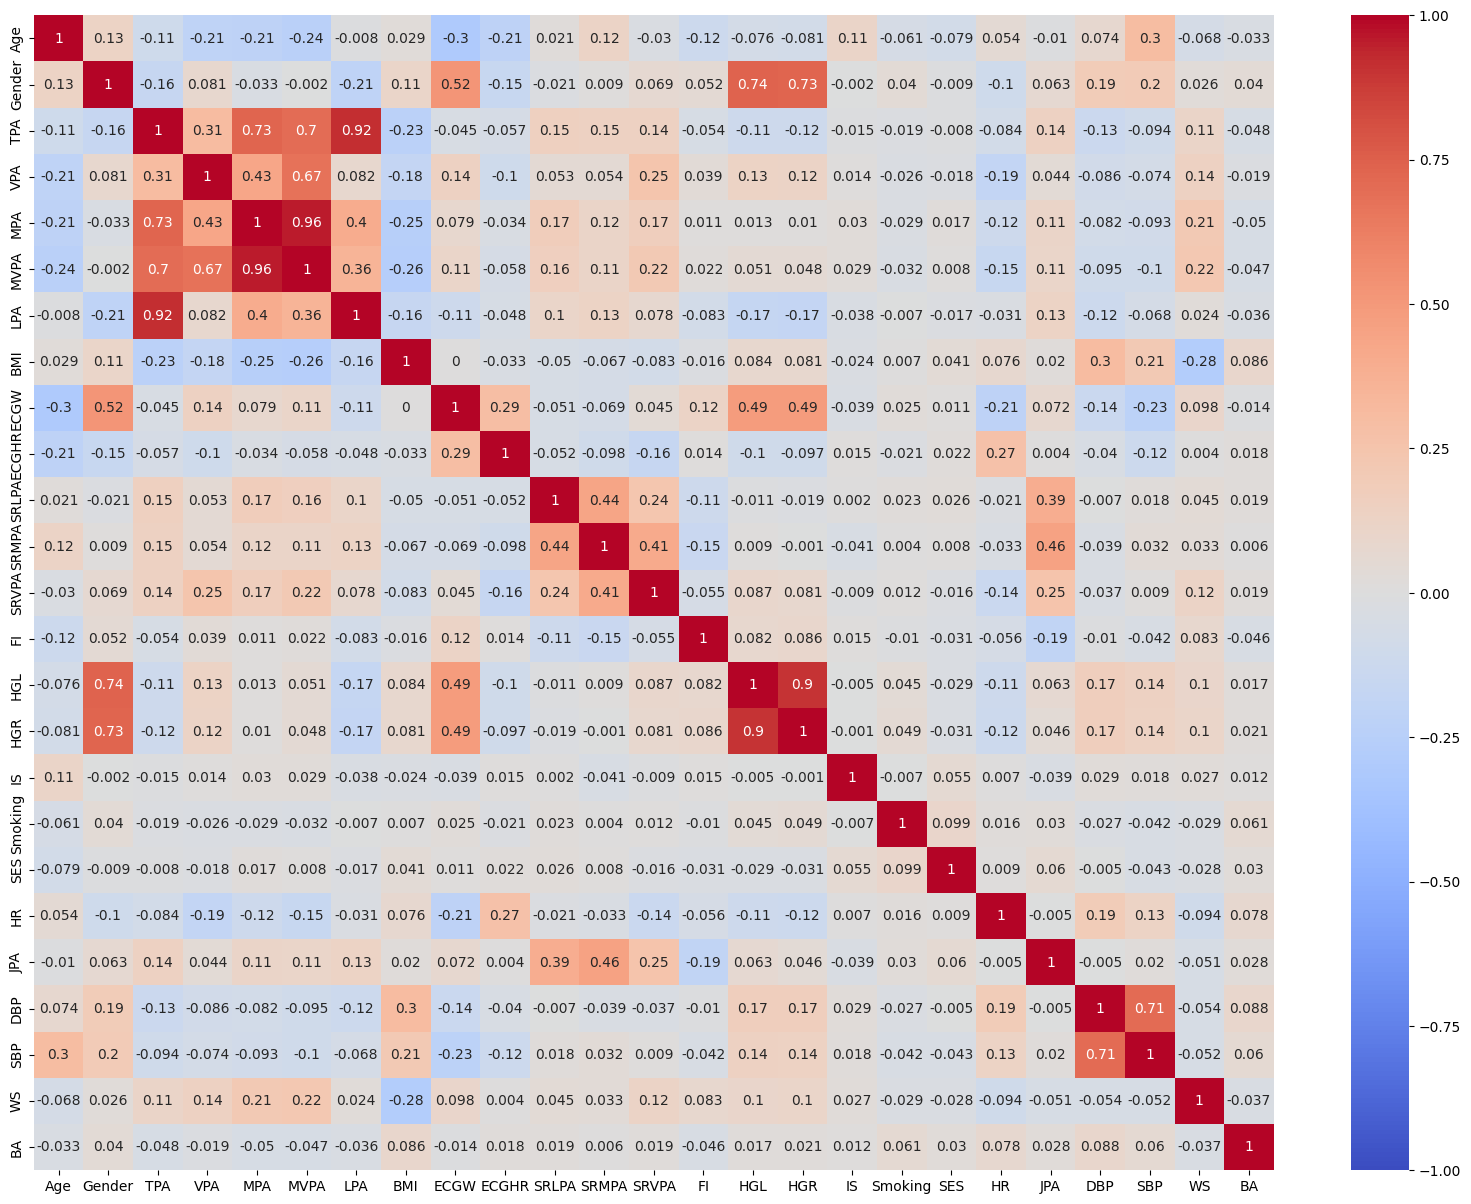

In [626]:
corr = main_test.corr()
corr = round(corr,3)
fig, ax = plt.subplots(figsize=(20,15)) 
sns.heatmap(corr, annot=True, cmap = "coolwarm", vmin=-1, vmax=1)

# 5 Partial correlations with Covariates

In [627]:
cov_correlation = pg.partial_corr(data=main_test, x='SRLPA', y='BA', covar=["Gender", "IS", "Age"])
print("SR Light PA")
print(cov_correlation)
cov_correlation = pg.partial_corr(data=main_test, x='SRMPA', y='BA', covar=["Gender", "IS", "Age"])
print("SR Moderate PA")
print(cov_correlation)
cov_correlation = pg.partial_corr(data=main_test, x='SRVPA', y='BA', covar=["Gender", "IS", "Age"])
print("SR Vigorous PA")
print(cov_correlation)
cov_correlation = pg.partial_corr(data=main_test, x='TPA', y='BA', covar=["Gender", "IS", "Age"])
print("Total PA")
print(cov_correlation)
cov_correlation = pg.partial_corr(data=main_test, x='LPA', y='BA', covar=["Gender", "IS", "Age"])
print("Light PA")
print(cov_correlation)
cov_correlation = pg.partial_corr(data=main_test, x='MPA', y='BA', covar=["Gender", "IS", "Age"])
print("Moderate PA")
print(cov_correlation)
cov_correlation = pg.partial_corr(data=main_test, x='VPA', y='BA', covar=["Gender", "IS", "Age"])
print("Vigorous PA")
print(cov_correlation)
cov_correlation = pg.partial_corr(data=main_test, x='MVPA', y='BA', covar=["Gender", "IS", "Age"])
print("Moderate+Vigorous PA")
print(cov_correlation)

SR Light PA
            n         r         CI95%     p-val
pearson  6394  0.020645  [-0.0, 0.05]  0.098876
SR Moderate PA
            n        r          CI95%     p-val
pearson  6394  0.01136  [-0.01, 0.04]  0.363889
SR Vigorous PA
            n         r          CI95%     p-val
pearson  6394  0.014649  [-0.01, 0.04]  0.241637
Total PA
            n        r           CI95%     p-val
pearson  7449 -0.04567  [-0.07, -0.02]  0.000081
Light PA
            n         r          CI95%     p-val
pearson  7449 -0.026788  [-0.05, -0.0]  0.020801
Moderate PA
            n         r           CI95%         p-val
pearson  7449 -0.059006  [-0.08, -0.04]  3.482788e-07
Vigorous PA
            n         r           CI95%     p-val
pearson  7449 -0.031913  [-0.05, -0.01]  0.005886
Moderate+Vigorous PA
            n        r           CI95%         p-val
pearson  7449 -0.05893  [-0.08, -0.04]  3.606516e-07


# 6 Models OLS

## 6.1 Covariates

In [628]:
cov_model = ols('BA ~ Gender + Age + IS + Gender:Age + Gender:IS + Age:IS', missing='drop', data = main_test).fit()
print(cov_model.summary())

#calculate effect size
results = cov_model
coefficients = results.params
t_stats = results.tvalues
effect_size = coefficients / t_stats
print(effect_size)

                            OLS Regression Results                            
Dep. Variable:                     BA   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     9.712
Date:                Fri, 06 Jan 2023   Prob (F-statistic):           1.11e-10
Time:                        16:07:30   Log-Likelihood:                -10541.
No. Observations:                7449   AIC:                         2.110e+04
Df Residuals:                    7442   BIC:                         2.114e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0086      0.012     -0.731      0.4

## 6.2 Accelerometer PA

In [629]:
pa_model = ols('BA ~ LPA + MPA + VPA + Gender + Age + IS + Gender:Age + Gender:IS + Age:IS', missing='drop', data = main_test).fit()
print(pa_model.summary())

#calculate effect size
results = pa_model
coefficients = results.params
t_stats = results.tvalues
effect_size = coefficients / t_stats
print(effect_size)

                            OLS Regression Results                            
Dep. Variable:                     BA   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     9.450
Date:                Fri, 06 Jan 2023   Prob (F-statistic):           1.96e-14
Time:                        16:07:32   Log-Likelihood:                -10527.
No. Observations:                7449   AIC:                         2.107e+04
Df Residuals:                    7439   BIC:                         2.114e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0084      0.012     -0.717      0.4

## 6.3 Self-report PA

In [630]:
sr_model = ols('BA ~ SRLPA + SRMPA + SRVPA +Gender + Age + IS + Gender:Age + Gender:IS + Age:IS', missing='drop', data = main_test).fit()
print(sr_model.summary())

#calculate effect size
results = sr_model
coefficients = results.params
t_stats = results.tvalues
effect_size = coefficients / t_stats
print(effect_size)

                            OLS Regression Results                            
Dep. Variable:                     BA   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     5.627
Date:                Fri, 06 Jan 2023   Prob (F-statistic):           8.78e-08
Time:                        16:07:35   Log-Likelihood:                -9045.2
No. Observations:                6394   AIC:                         1.811e+04
Df Residuals:                    6384   BIC:                         1.818e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0098      0.013     -0.771      0.4

## 6.4 SR + Job PA + FI

In [631]:
sr_ex_model = ols('BA ~ SRLPA + SRMPA + SRVPA + FI + JPA + Gender + Age + IS + Gender:Age + Gender:IS + Age:IS', missing='drop', data = main_test).fit()
print(sr_ex_model.summary())

#calculate effect size
results = sr_ex_model
coefficients = results.params
t_stats = results.tvalues
effect_size = coefficients / t_stats
print(effect_size)

                            OLS Regression Results                            
Dep. Variable:                     BA   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     5.032
Date:                Fri, 06 Jan 2023   Prob (F-statistic):           7.96e-08
Time:                        16:07:39   Log-Likelihood:                -4290.3
No. Observations:                3048   AIC:                             8605.
Df Residuals:                    3036   BIC:                             8677.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0656      0.020     -3.305      0.0

## 6.5 Accelerometer + Self-report PA

In [632]:
sr_pa_model = ols('BA ~ SRLPA + SRMPA + SRVPA +LPA + MPA + VPA+ Gender + Age + IS + Gender:Age + Gender:IS + Age:IS', missing='drop', data = main_test).fit()
print(sr_pa_model.summary())

#calculate effect size
results = sr_pa_model
coefficients = results.params
t_stats = results.tvalues
effect_size = coefficients / t_stats
print(effect_size)

                            OLS Regression Results                            
Dep. Variable:                     BA   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     5.986
Date:                Fri, 06 Jan 2023   Prob (F-statistic):           1.69e-10
Time:                        16:07:43   Log-Likelihood:                -9034.6
No. Observations:                6394   AIC:                         1.810e+04
Df Residuals:                    6381   BIC:                         1.818e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0090      0.013     -0.713      0.4

## 6.6 PA + Fitness

In [633]:
pa_fitness = ols('BA ~ HGR + HGL + ECGW + LPA + MPA + VPA + Age + Gender + IS+ Gender:Age + Gender:IS + Age:IS', missing='drop', data = main_test).fit()
print(pa_fitness.summary())

#calculate effect size
results = pa_fitness
coefficients = results.params
t_stats = results.tvalues
effect_size = coefficients / t_stats
print(effect_size)

                            OLS Regression Results                            
Dep. Variable:                     BA   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     3.014
Date:                Fri, 06 Jan 2023   Prob (F-statistic):           0.000349
Time:                        16:07:48   Log-Likelihood:                -1759.4
No. Observations:                1264   AIC:                             3545.
Df Residuals:                    1251   BIC:                             3612.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0310      0.035     -0.877      0.3

## 6.7 Fitness

In [634]:
fitness = ols('BA ~ HGR + HGL + ECGW + Age + Gender + IS+ Gender:Age + Gender:IS + Age:IS', missing='drop', data = main_test).fit()
print(fitness.summary())

#calculate effect size
results = fitness
coefficients = results.params
t_stats = results.tvalues
effect_size = coefficients / t_stats
print(effect_size)

                            OLS Regression Results                            
Dep. Variable:                     BA   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     3.067
Date:                Fri, 06 Jan 2023   Prob (F-statistic):            0.00121
Time:                        16:07:51   Log-Likelihood:                -1763.6
No. Observations:                1264   AIC:                             3547.
Df Residuals:                    1254   BIC:                             3599.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0305      0.035     -0.863      0.3

## 6.8 Health

In [635]:
health = ols('BA ~ ECGHR + SBP + HR + DBP + Age + Gender + IS+ Gender:Age + Gender:IS + Age:IS', missing='drop', data = main_test).fit()
print(health.summary())

#calculate effect size
results = health
coefficients = results.params
t_stats = results.tvalues
effect_size = coefficients / t_stats
print(effect_size)

                            OLS Regression Results                            
Dep. Variable:                     BA   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     2.784
Date:                Fri, 06 Jan 2023   Prob (F-statistic):            0.00210
Time:                        16:07:56   Log-Likelihood:                -1460.9
No. Observations:                1056   AIC:                             2944.
Df Residuals:                    1045   BIC:                             2998.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0221      0.041     -0.542      0.5

## 6.9 Health and Fitness

In [636]:
he_fi = ols('BA ~ HGR + SBP + HR + DBP + Age + Gender + IS+ Gender:Age + Gender:IS + Age:IS', missing='drop', data = main_test).fit()
print(he_fi.summary())

#calculate effect size
results = he_fi
coefficients = results.params
t_stats = results.tvalues
effect_size = coefficients / t_stats
print(effect_size)

                            OLS Regression Results                            
Dep. Variable:                     BA   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     11.28
Date:                Fri, 06 Jan 2023   Prob (F-statistic):           2.26e-19
Time:                        16:07:59   Log-Likelihood:                -8273.8
No. Observations:                5868   AIC:                         1.657e+04
Df Residuals:                    5857   BIC:                         1.664e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0202      0.013     -1.533      0.1

## 6.10 Fluid intelligence

In [637]:
fi = ols('BA ~ FI + Age + Gender + IS+ Gender:Age + Gender:IS + Age:IS', missing='drop', data = main_test).fit()
print(fi.summary())

#calculate effect size
results = fi
coefficients = results.params
t_stats = results.tvalues
effect_size = coefficients / t_stats
print(effect_size)

                            OLS Regression Results                            
Dep. Variable:                     BA   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     7.442
Date:                Fri, 06 Jan 2023   Prob (F-statistic):           6.22e-09
Time:                        16:08:02   Log-Likelihood:                -7476.0
No. Observations:                5301   AIC:                         1.497e+04
Df Residuals:                    5293   BIC:                         1.502e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0158      0.014     -1.146      0.2

## 6.11 Fitness models

In [638]:
fit = ols('HGR ~ LPA + MPA + VPA + Age + Gender + IS+ Gender:Age + Gender:IS + Age:IS', missing='drop', data = main_test).fit()
print(fit.summary())

#calculate effect size
results = fit
coefficients = results.params
t_stats = results.tvalues
effect_size = coefficients / t_stats
print(effect_size)

                            OLS Regression Results                            
Dep. Variable:                    HGR   R-squared:                       0.561
Model:                            OLS   Adj. R-squared:                  0.560
Method:                 Least Squares   F-statistic:                     1052.
Date:                Fri, 06 Jan 2023   Prob (F-statistic):               0.00
Time:                        16:08:07   Log-Likelihood:                -7481.6
No. Observations:                7425   AIC:                         1.498e+04
Df Residuals:                    7415   BIC:                         1.505e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0017      0.008     -0.217      0.8

In [639]:
fit2 = ols('HGR ~ LPA + MPA + VPA + SRLPA + SRMPA + SRVPA + Age + Gender + IS+ Gender:Age + Gender:IS + Age:IS', missing='drop', data = main_test).fit()
print(fit2.summary())

#calculate effect size
results = fit2
coefficients = results.params
t_stats = results.tvalues
effect_size = coefficients / t_stats
print(effect_size)

                            OLS Regression Results                            
Dep. Variable:                    HGR   R-squared:                       0.558
Model:                            OLS   Adj. R-squared:                  0.557
Method:                 Least Squares   F-statistic:                     667.9
Date:                Fri, 06 Jan 2023   Prob (F-statistic):               0.00
Time:                        16:08:13   Log-Likelihood:                -6441.8
No. Observations:                6373   AIC:                         1.291e+04
Df Residuals:                    6360   BIC:                         1.300e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0026      0.008     -0.309      0.7

# 7 Model comparisons

## 7.1 Cov x PA

In [640]:
model_comparison = anova_lm(cov_model, pa_model)
print(model_comparison)

   df_resid          ssr  df_diff    ss_diff         F    Pr(>F)
0    7442.0  7391.125419      0.0        NaN       NaN       NaN
1    7439.0  7364.801407      3.0  26.324012  8.863073  0.000007


In [641]:
model_comparison = anova_lm(cov_model, sr_model)
print(model_comparison)

   df_resid          ssr  df_diff     ss_diff         F    Pr(>F)
0    7442.0  7391.125419      0.0         NaN       NaN       NaN
1    6384.0  6339.161379   1058.0  1051.96404  1.001328  0.484258


## 7.2 Cov x PA x SR

In [642]:
model_comparison = anova_lm(pa_model, sr_pa_model)
print(model_comparison)

   df_resid          ssr  df_diff      ss_diff         F    Pr(>F)
0    7439.0  7364.801407      0.0          NaN       NaN       NaN
1    6381.0  6318.322446   1058.0  1046.478961  0.998922  0.504692


In [643]:
model_comparison = anova_lm(sr_model, sr_pa_model)
print(model_comparison)

   df_resid          ssr  df_diff    ss_diff         F    Pr(>F)
0    6384.0  6339.161379      0.0        NaN       NaN       NaN
1    6381.0  6318.322446      3.0  20.838933  7.015218  0.000105


## 7.3 SR x Job + FI

In [644]:
model_comparison = anova_lm(sr_model, sr_ex_model)
print(model_comparison)

   df_resid          ssr  df_diff      ss_diff        F    Pr(>F)
0    6384.0  6339.161379      0.0          NaN      NaN       NaN
1    3036.0  2979.441784   3348.0  3359.719595  1.02255  0.264861


## 7.4 Fitness models

In [645]:
model_comparison = anova_lm(fit, fit2)
print(model_comparison)

   df_resid          ssr  df_diff     ss_diff         F    Pr(>F)
0    7415.0  3261.619411      0.0         NaN       NaN       NaN
1    6360.0  2817.343725   1055.0  444.275686  0.950643  0.855168


# 8 Mediation analysis

## 8.1 PA x Health / Fitness

### 8.1.1 BMI

In [646]:
#regression of x on m
model1 = ols('BMI ~ MPA', data = main_test).fit()
#regression of y on m
model2 = ols('BA ~ BMI',data = main_test).fit()
#regression of y on x
model3 = ols('BA ~ MPA', data = main_test).fit()
#calculate the indirect effect
indirect_effect = model1.params['MPA'] * model2.params['BMI']
#calculate the total effect
total_effect = model3.params['MPA']
#calculate the direct effect
direct_effect = total_effect - indirect_effect
#print the results
print('Indirect effect: '+str(indirect_effect))
print('Direct effect: '+str(direct_effect))
print('Total effect: '+str(total_effect))

Indirect effect: -0.021604478687059947
Direct effect: -0.028267448403812255
Total effect: -0.0498719270908722


### 8.1.2 DBP

In [647]:
#regression of x on m
model1 = ols('DBP ~ MPA', data = main_test).fit()
#regression of y on m
model2 = ols('BA ~ DBP',data = main_test).fit()
#regression of y on x
model3 = ols('BA ~ MPA', data = main_test).fit()
#calculate the indirect effect
indirect_effect = model1.params['MPA'] * model2.params['DBP']
#calculate the total effect
total_effect = model3.params['MPA']
#calculate the direct effect
direct_effect = total_effect - indirect_effect
#print the results
print('Indirect effect: '+str(indirect_effect))
print('Direct effect: '+str(direct_effect))
print('Total effect: '+str(total_effect))

Indirect effect: -0.007251406999023727
Direct effect: -0.042620520091848475
Total effect: -0.0498719270908722


### 8.1.3 Heart rate

In [648]:
#regression of x on m
model1 = ols('HR ~ MPA', data = main_test).fit()
#regression of y on m
model2 = ols('BA ~ HR',data = main_test).fit()
#regression of y on x
model3 = ols('BA ~ MPA', data = main_test).fit()
#calculate the indirect effect
indirect_effect = model1.params['MPA'] * model2.params['HR']
#calculate the total effect
total_effect = model3.params['MPA']
#calculate the direct effect
direct_effect = total_effect - indirect_effect
#print the results
print('Indirect effect: '+str(indirect_effect))
print('Direct effect: '+str(direct_effect))
print('Total effect: '+str(total_effect))

Indirect effect: -0.00902390461127259
Direct effect: -0.04084802247959961
Total effect: -0.0498719270908722


### 8.1.4 Hand grip

In [649]:
#regression of x on m
model1 = ols('HGR ~ MPA', data = main_test).fit()
#regression of y on m
model2 = ols('BA ~ HGR',data = main_test).fit()
#regression of y on x
model3 = ols('BA ~ MPA', data = main_test).fit()
#calculate the indirect effect
indirect_effect = model1.params['MPA'] * model2.params['HGR']
#calculate the total effect
total_effect = model3.params['MPA']
#calculate the direct effect
direct_effect = total_effect - indirect_effect
#print the results
print('Indirect effect: '+str(indirect_effect))
print('Direct effect: '+str(direct_effect))
print('Total effect: '+str(total_effect))

Indirect effect: 0.0002130217942451666
Direct effect: -0.050084948885117365
Total effect: -0.0498719270908722


## 8.2 SR PA x Job PA / Fluid intelligence

In [650]:
#regression of x on m
model1 = ols('FI ~ SRMPA', data = main_test).fit()
#regression of y on m
model2 = ols('BA ~ FI',data = main_test).fit()
#regression of y on x
model3 = ols('BA ~ SRMPA', data = main_test).fit()
#calculate the indirect effect
indirect_effect = model1.params['SRMPA'] * model2.params['FI']
#calculate the total effect
total_effect = model3.params['SRMPA']
#calculate the direct effect
direct_effect = total_effect - indirect_effect
#print the results
print('Indirect effect: '+str(indirect_effect))
print('Direct effect: '+str(direct_effect))
print('Total effect: '+str(total_effect))

Indirect effect: 0.0067390496236435435
Direct effect: -0.0008458203030053141
Total effect: 0.005893229320638229


In [651]:
#regression of x on m
model1 = ols('FI ~ SRVPA', data = main_test).fit()
#regression of y on m
model2 = ols('BA ~ FI',data = main_test).fit()
#regression of y on x
model3 = ols('BA ~ SRVPA', data = main_test).fit()
#calculate the indirect effect
indirect_effect = model1.params['SRVPA'] * model2.params['FI']
#calculate the total effect
total_effect = model3.params['SRVPA']
#calculate the direct effect
direct_effect = total_effect - indirect_effect
#print the results
print('Indirect effect: '+str(indirect_effect))
print('Direct effect: '+str(direct_effect))
print('Total effect: '+str(total_effect))

Indirect effect: 0.0025420912078623565
Direct effect: 0.01610895879140065
Total effect: 0.018651049999263005


In [652]:
#regression of x on m
model1 = ols('FI ~ JPA', data = main_test).fit()
#regression of y on m
model2 = ols('BA ~ FI',data = main_test).fit()
#regression of y on x
model3 = ols('BA ~ JPA', data = main_test).fit()
#calculate the indirect effect
indirect_effect = model1.params['JPA'] * model2.params['FI']
#calculate the total effect
total_effect = model3.params['JPA']
#calculate the direct effect
direct_effect = total_effect - indirect_effect
#print the results
print('Indirect effect: '+str(indirect_effect))
print('Direct effect: '+str(direct_effect))
print('Total effect: '+str(total_effect))

Indirect effect: 0.008935796834274956
Direct effect: 0.018596069857752598
Total effect: 0.027531866692027552


# 9 LASSO Regression

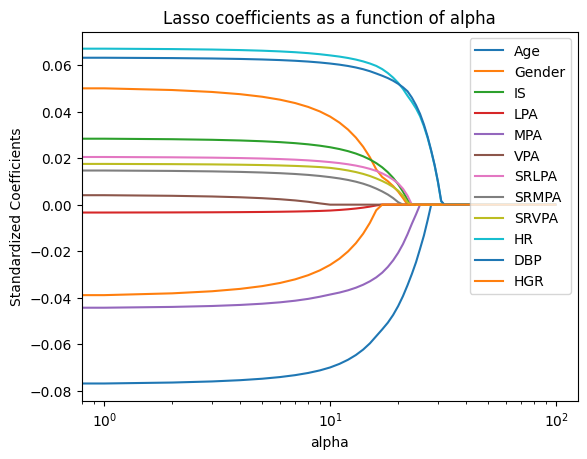

In [653]:
df = main_test[["Age", "Gender", "IS", "LPA", "MPA", "VPA",  "SRLPA", "SRMPA", "SRVPA", "HR", "DBP", "HGR", "BA"]]
df = df.dropna()
df = pd.DataFrame(df)
X = df[["Age", "Gender", "IS", "LPA", "MPA", "VPA",  "SRLPA", "SRMPA", "SRVPA", "HR", "DBP", "HGR"]]
Y = df["BA"]
columns = ["Age", "Gender", "IS", "LPA", "MPA", "VPA",  "SRLPA", "SRMPA", "SRVPA", "HR", "DBP", "HGR"]

coefs = []
alphas = np.power(10,np.linspace(start=-3, stop=3, num=100))

for a in alphas:
    lasso = Lasso(alpha=a)
    lasso.fit(X,Y)
    coefs.append(lasso.coef_)

coefs = pd.DataFrame(coefs)
coefs.columns = columns
coefs = pd.DataFrame(coefs)

plt.plot(coefs)
plt.xticks(alphas)
plt.xscale("log")
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Standardized Coefficients')
plt.title('Lasso coefficients as a function of alpha')
plt.legend(columns, loc="upper right")

# 10 Figures for Paper

## 10.1 Scatterplot of MPA duration categories BrainAGE x AGE

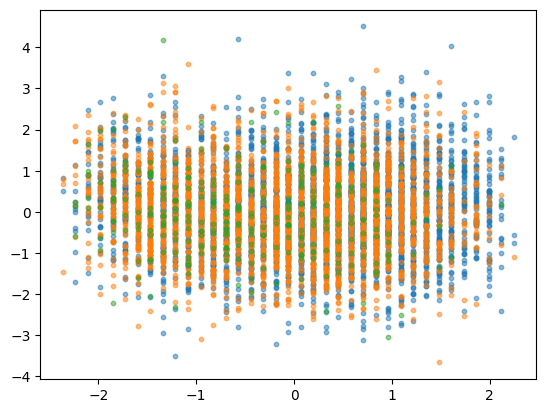

In [654]:
# for standardized data
mpa1 = main_test[main_test["MPA"]<0]
mpa2 = main_test[(main_test["MPA"]>=0) & (main_test["MPA"]<=2)]
mpa3 = main_test[main_test["MPA"]>2]
plt.figure()
plt.scatter(mpa1["Age"], mpa1["BA"], alpha=0.5, s=10)
plt.scatter(mpa2["Age"], mpa2["BA"], alpha=0.5, s=10)
plt.scatter(mpa3["Age"], mpa3["BA"], alpha=0.5, s=10)
plt.show()


## 10.2 Smaller Correlation Heatmap

<AxesSubplot:>

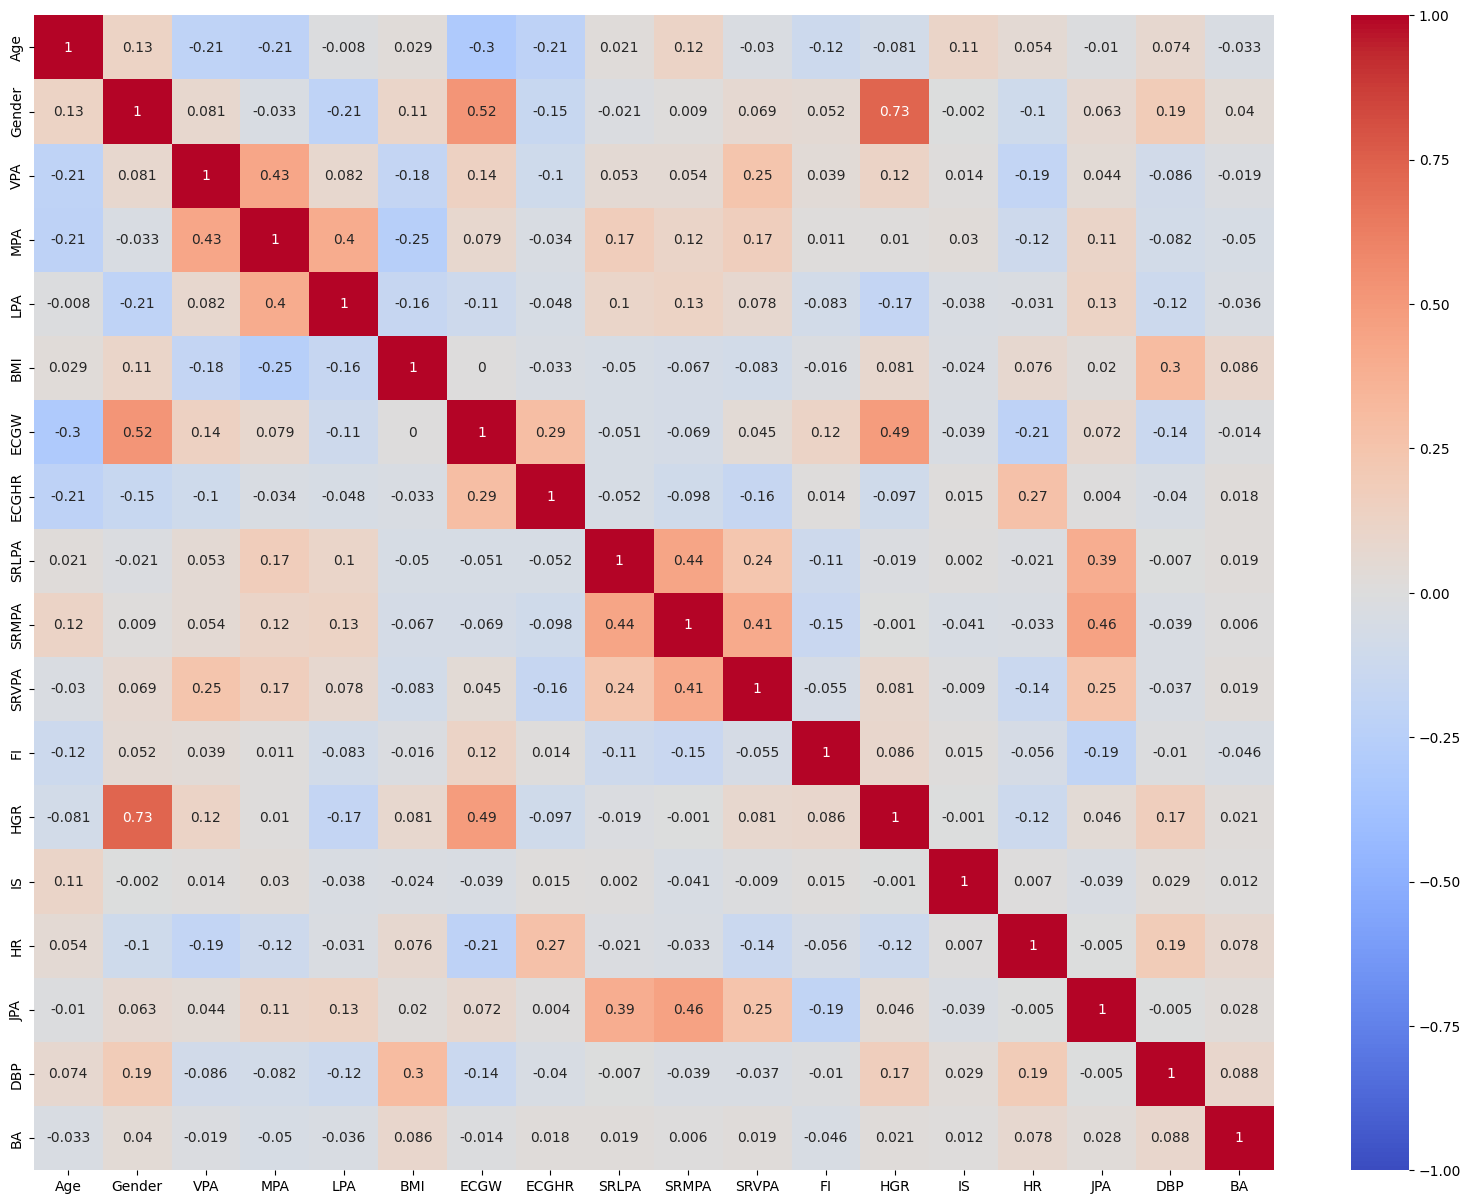

In [655]:
x = main_test
del x["HGL"]
del x["Smoking"]
del x["MVPA"]
del x["SES"]
del x["WS"]
del x["TPA"]
del x["SBP"]
corr = x.corr()
corr = round(corr,3)
fig, ax = plt.subplots(figsize=(20,15)) 
sns.heatmap(corr, annot=True, cmap = "coolwarm", vmin=-1, vmax=1)


# 11 Exploration vs. Validation

## 11.1 Import processed Validation set

In [656]:
validate = pd.read_pickle("6_main_test.pkl")
validate = pd.DataFrame(validate)

## 11.2 BrainAGE distribution

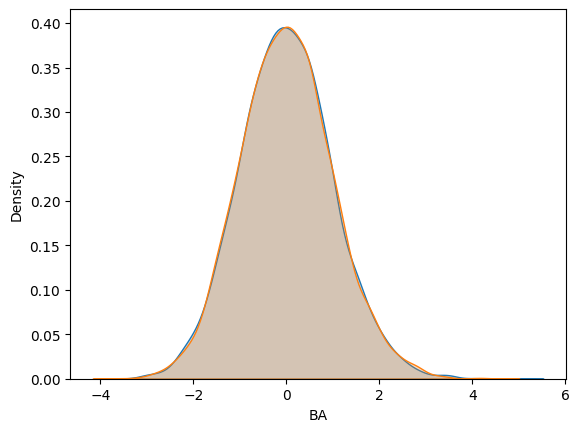

In [657]:
plt.figure()
sns.kdeplot(data = validate, x= 'BA', fill=True, label = "Validate")
sns.kdeplot(data = main_test, x= 'BA', fill=True, label = "Explore")
plt.show()

## 11.3 MPA distribution

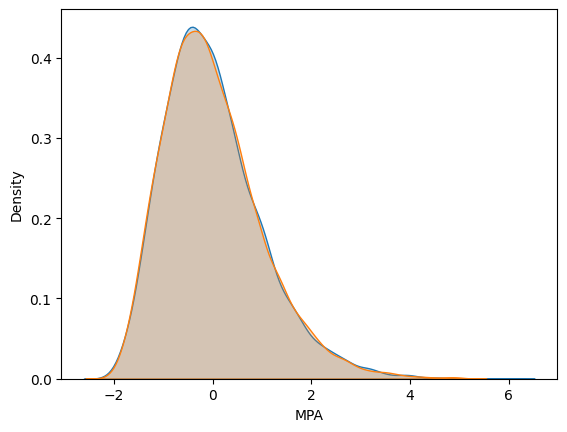

In [658]:
plt.figure()
sns.kdeplot(data = validate, x= 'MPA', fill=True, label = "Validate")
sns.kdeplot(data = main_test, x= 'MPA', fill=True, label = "Explore")
plt.show()

## 11.4 Correlation heatmap

<AxesSubplot:>

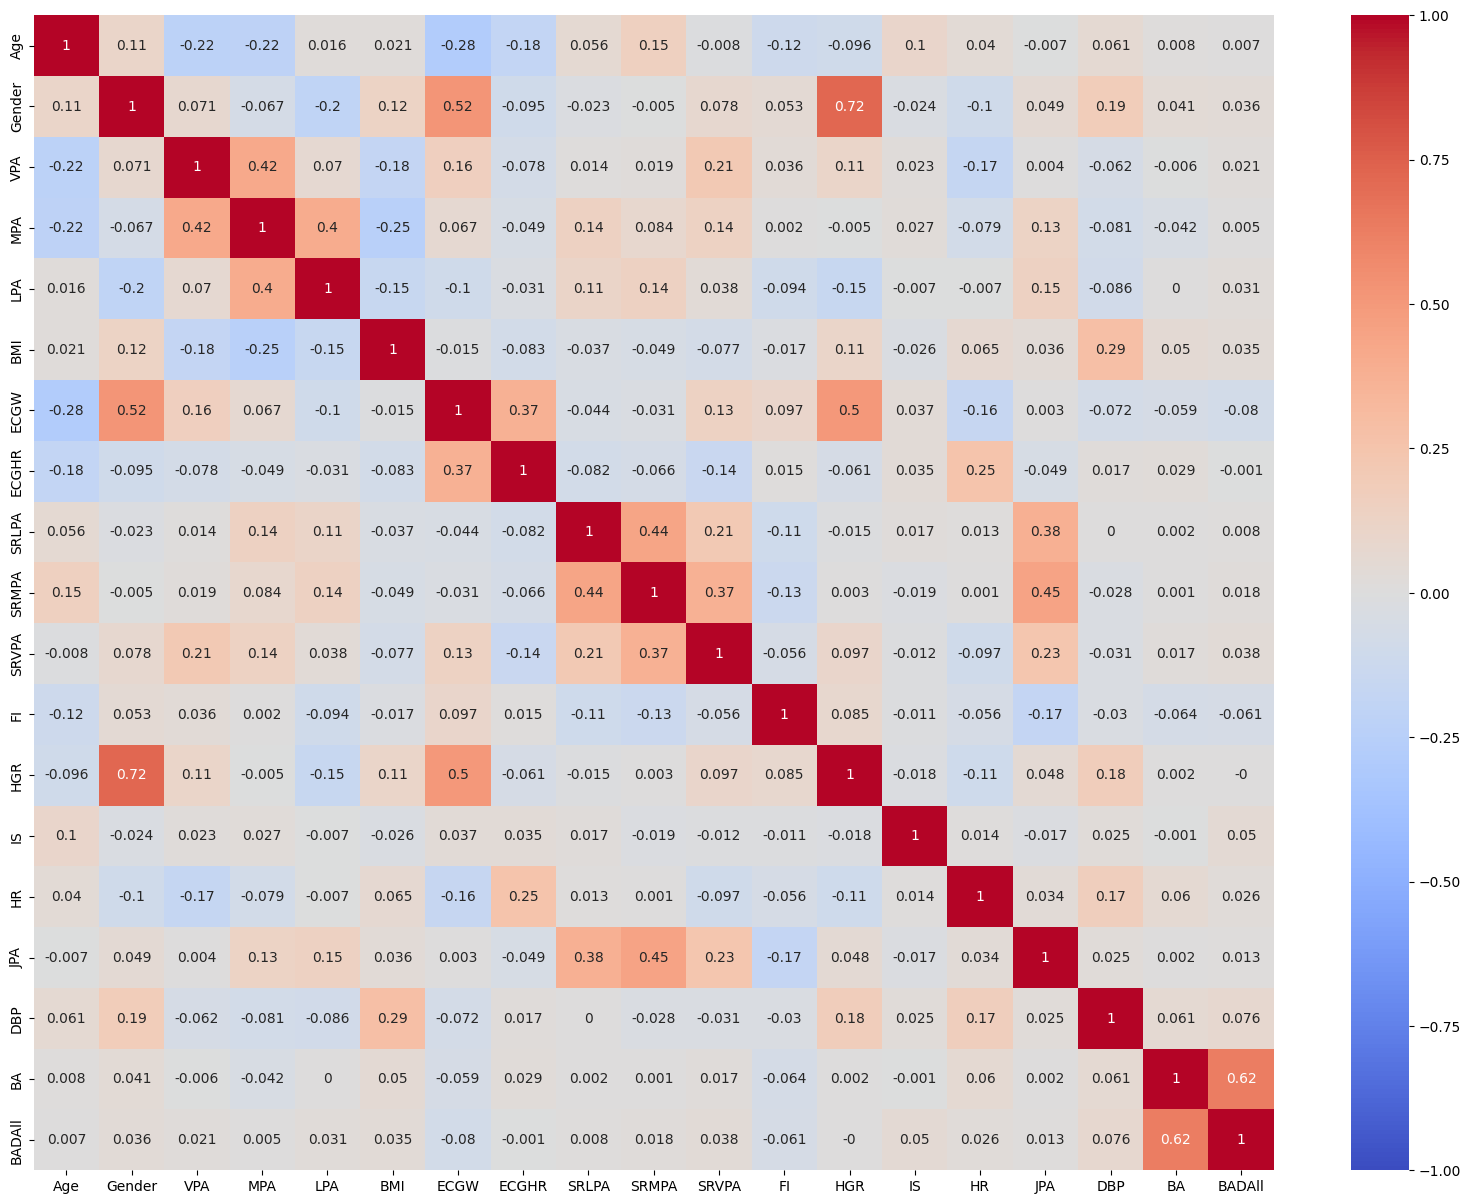

In [659]:
x = validate
del x["HGL"]
del x["Smoking"]
del x["MVPA"]
del x["SES"]
del x["WS"]
del x["TPA"]
del x["SBP"]
corr = x.corr()
corr = round(corr,3)
fig, ax = plt.subplots(figsize=(20,15)) 
sns.heatmap(corr, annot=True, cmap = "coolwarm", vmin=-1, vmax=1)